In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
#from datetime import datetime

#from keras.layers import Dense,Dropout, Flatten,LSTM,RepeatVector,TimeDistributed,Conv1D,MaxPooling1D
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from livelossplot.keras import PlotLossesCallback

#from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
power = pd.DataFrame(pd.read_excel("power.xlsx"))
wind = pd.DataFrame(pd.read_excel("Wind.xlsx"))
humidity = pd.DataFrame(pd.read_excel("Humidity.xlsx"))
solar = pd.DataFrame(pd.read_excel("Solar.xlsx"))
temperature = pd.DataFrame(pd.read_excel("Temperature.xlsx"))
power.head()

,Day1,Day2,Day3,Day4,Day5,Day6,Day7,Day8,Day9,Day10,...,Day13,Day14,Day15,Day16,Day17,Day18,Day19,Day20,Day21,Day22
0,5788.555960,1134.817750,6049.283365,6024.686440,6372.732929,5698.777184,5309.093606,993.526012,5632.361700,5842.547419,...,1163.104214,1275.020223,5803.214419,5967.921356,853.402200,5327.530950,811.610888,5428.321763,991.067700,1099.233450
1,5790.605704,1105.711389,5941.056895,5997.219874,6117.744806,5690.168260,5228.379012,1029.171544,5649.979606,5867.130544,...,1164.744009,1849.358421,5832.304450,6112.142356,916.089169,5405.787231,925.512700,5366.454232,1036.546481,3560.413981
2,5771.830051,1126.946734,5931.710063,6012.387978,6008.944408,5717.224878,5210.269444,1025.975737,5644.407431,5844.514069,...,1158.184829,3279.423641,5822.880919,6065.762194,963.288769,5377.434694,927.643238,5432.746725,977.301150,4227.681938
3,5748.146726,1141.318366,5926.825817,6008.698439,5915.405816,5718.103339,5210.936700,987.731419,5654.135325,5859.228825,...,1445.968851,4024.429361,5846.059294,6043.426669,1006.168763,5393.729794,913.104075,5468.005950,985.624294,4662.381825
4,5793.202046,1153.812042,5930.261578,5996.946575,5893.229541,5708.206005,5159.546262,978.229846,5652.847638,5853.336679,...,2448.566844,4752.752118,5865.081950,6043.036461,1128.186908,5328.486961,950.915263,5447.715117,980.415013,5177.983606


In [3]:
#fill missing data pts with center averages (avg over the row and column of the missing pt)
def fill_empty(df):
    emptyIndexes = np.where(pd.isnull(df))
    row = emptyIndexes[0]
    col = emptyIndexes[1]
    
    colAvg = df.iloc[:,col].mean()
    rowAvg = df.iloc[row].mean(axis=1)
    rowAvg = rowAvg.to_numpy()
    
    for i in range(len(row)):
        df.iloc[[row[i]],[col[i]]] = (colAvg[i] + rowAvg[i])/2

fill_empty(power)
fill_empty(wind)
fill_empty(humidity)
fill_empty(solar)
fill_empty(temperature)

In [4]:
#reduce dataset size by n (by combining and taking avg)
def reduce_dataset(df,n):
    arr = []  
    sum = 0
    k = 0
    for i in range(len(df)):
        sum += df[i]
        k+=1
        if (i+1)%n == 0:
            avg = sum/n
            arr.append(avg)
            sum = 0
            k = 0
        elif i == len(df)-1:  #account for the remainders (dataset size divided by n) 
            avg = sum/k
            arr.append(avg)
    return arr

In [5]:
#training_set = 16 days ,testing_set = 6

#get training data split
def merge_cols(df):
    arr = []
    for i in range(len(df.columns)-6):   #subtract here to save for test set
        arr.append(reduce_dataset(df.iloc[:,i],12*10))   #datapts are going by every 10 mins now
    arr = np.array(arr)
    return arr.flatten()

#get testing data split
def merge_cols2(df):
    arr = []
    for i in range(16,len(df.columns)):   #subtract here to save for test set
        arr.append(reduce_dataset(df.iloc[:,i],12*10))   #datapts are going by every 10 mins now
    arr = np.array(arr)
    return arr.flatten()

#training set split
combined_df = pd.DataFrame() 
combined_df['power'] = merge_cols(power)
combined_df['wind'] = merge_cols(wind)
combined_df['humidity'] = merge_cols(humidity)
combined_df['solar'] = merge_cols(solar)
combined_df['temperature'] = merge_cols(temperature)
print(combined_df)

#testing set split
combined_df_testing = pd.DataFrame() 
combined_df_testing['power'] = merge_cols2(power)
combined_df_testing['wind'] = merge_cols2(wind)
combined_df_testing['humidity'] = merge_cols2(humidity)
combined_df_testing['solar'] = merge_cols2(solar)
combined_df_testing['temperature'] = merge_cols2(temperature)
print(combined_df_testing)

            power       wind   humidity     solar  temperature
0     4403.110451   3.602343  45.106079  6.995357    74.931156
1     3899.838388   2.894487  46.472482  6.922708    74.455069
2     3763.889029   2.380182  47.976456  5.956574    73.690198
3     3822.103970   2.190887  48.255275  7.031028    73.202496
4     3659.193612   1.827199  47.864774  6.230081    73.009820
...           ...        ...        ...       ...          ...
2299  2976.901619   6.991782  73.310856  7.245872    70.682968
2300  2957.302068   9.417448  71.383882  6.289153    71.892544
2301  2933.093814   9.239334  72.588402  5.012024    71.392333
2302  3113.878834  11.825803  66.255089  6.064669    73.477768
2303  2401.135489   8.535590  64.451716  8.683582    73.931015

[2304 rows x 5 columns]
           power      wind   humidity     solar  temperature
0    3559.037559  7.437763  59.945661  6.408486    74.838363
1    2876.424537  5.744709  59.403534  5.932505    75.244082
2    3586.248966  6.114873  58.16224

<AxesSubplot:>

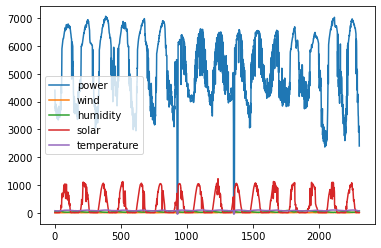

In [6]:
#training dataset split
combined_df.plot()

In [7]:
#(training data split)
#Variables for training
cols = list(combined_df.iloc[:,])
print(cols)

#New dataframe with only training data 
training_df = combined_df[cols].astype(float)

#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(training_df)
training_df_scaled = scaler.transform(training_df)
print(training_df_scaled)

['power', 'wind', 'humidity', 'solar', 'temperature']
[[-0.66995938 -0.58647229  0.30519776 -0.81699403 -0.63881694]
 [-1.07307461 -0.80628499  0.38762159 -0.81718542 -0.67388234]
 [-1.18196851 -0.96599361  0.47834396 -0.81973057 -0.73021757]
 ...
 [-1.84742608  1.16400093  1.9629795  -0.82221887 -0.89946275]
 [-1.70261933  1.96718527  1.58094298 -0.81944581 -0.74586368]
 [-2.27351869  0.94546495  1.4721604  -0.81254662 -0.71248061]]


<AxesSubplot:>

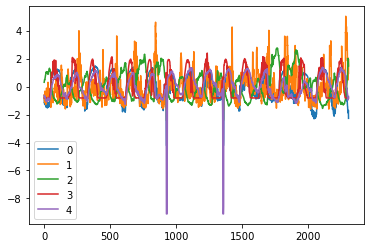

In [8]:
plot_training_scaled = pd.DataFrame(training_df_scaled)
plot_training_scaled.plot()

In [9]:
#(testing data split)
#Variables for training
cols2 = list(combined_df_testing.iloc[:,])
print(cols2)

#New dataframe with only training data 
testing_df = combined_df_testing[cols2].astype(float)
# df_for_plot=df_for_training.tail(5000)
# df_for_plot.plot.line()

#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(testing_df)
testing_df_scaled = scaler.transform(testing_df)
print(testing_df_scaled)

['power', 'wind', 'humidity', 'solar', 'temperature']
[[-1.37925392  0.24455688  1.50519269 -0.81273953 -1.15282619]
 [-2.0978043  -0.25820225  1.46961439 -0.81403885 -1.10575115]
 [-1.35060992 -0.14828061  1.38815181 -0.81646279 -1.08037906]
 ...
 [-1.01735505 -1.27340441 -0.3256859  -0.80852968 -0.98783014]
 [-1.07735859 -1.03209336 -0.28909494 -0.80673147 -1.1289314 ]
 [-1.20113342 -0.94880051 -0.20689147 -0.80404902 -1.18443855]]


In [10]:
'''
Reformat input data into a shape: (n_samples x timesteps x n_features)

n_past = # of past days we want to use to predict the future
n_future = # of days we want to look into the future based on the past days

ex:
n_past = 5   n_future = 2

train_x = 12345   train_y = 67
        = 23456           = 78
        = 34567           = 89
'''
def training_data_split(data, n_past = 14, n_future = 1):
    trainX = []
    trainY = []

    for i in range(n_past, len(data) - n_future +1):
        trainX.append(data[i - n_past:i, 0:data.shape[1]])
        trainY.append(data[i + n_future - 1:i + n_future, 0])

    #print(data[14 - n_past:14, 0:data.shape[1]])
    #print(data[14 - n_past:14])
    trainX, trainY = np.array(trainX,dtype=np.float16), np.array(trainY,dtype=np.float16)
    #print(trainX[len(trainX)-1])
    #print(trainX[0])
    print(trainX)
    print(trainY)
    print('trainX shape == {}.'.format(trainX.shape))
    print('trainY shape == {}.'.format(trainY.shape))
    
    return trainX, trainY

#n_past = (training_df_scaled.shape[0]*training_df_scaled.shape[1])-len(power) #subtract last power excel column
#n_past = len(training_df_scaled) - len(power)
#trainX, trainY = training_data_split(training_df_scaled)
#n_past = len(training_df_scaled) - len(power)
#print(n_past)
print(len(combined_df))
n_past = len(combined_df)-(len(combined_df)/16)
n_past = 720
print(n_past)
trainX, trainY = training_data_split(training_df_scaled, int(n_past))
#trainX, trainY = training_data_split(df_for_training_scaled5)
#trainX, trainY = training_data_split(power_training_df_scaled)

2304
720
[[[-0.67     -0.5864    0.3052   -0.817    -0.6387  ]
  [-1.073    -0.806     0.3877   -0.8174   -0.674   ]
  [-1.182    -0.966     0.4783   -0.82     -0.73    ]
  ...
  [-0.818     0.2028    1.35     -0.816    -0.653   ]
  [-0.737    -0.1753    1.439    -0.811    -0.6157  ]
  [-0.6294   -0.081     1.459    -0.812    -0.6694  ]]

 [[-1.073    -0.806     0.3877   -0.8174   -0.674   ]
  [-1.182    -0.966     0.4783   -0.82     -0.73    ]
  [-1.136    -1.024     0.495    -0.817    -0.766   ]
  ...
  [-0.737    -0.1753    1.439    -0.811    -0.6157  ]
  [-0.6294   -0.081     1.459    -0.812    -0.6694  ]
  [-0.728    -0.4258    1.501    -0.8115   -0.66    ]]

 [[-1.182    -0.966     0.4783   -0.82     -0.73    ]
  [-1.136    -1.024     0.495    -0.817    -0.766   ]
  [-1.266    -1.138     0.4717   -0.819    -0.7803  ]
  ...
  [-0.6294   -0.081     1.459    -0.812    -0.6694  ]
  [-0.728    -0.4258    1.501    -0.8115   -0.66    ]
  [-1.052    -0.907     1.528    -0.8135   -0.676  

In [11]:
print(len(combined_df_testing))
n_past = len(combined_df_testing)-(len(combined_df_testing)/6)
print(n_past)
testX, testY = training_data_split(testing_df_scaled, int(n_past))

864
720.0
[[[-1.379   0.2445  1.505  -0.8125 -1.152 ]
  [-2.098  -0.2583  1.47   -0.814  -1.105 ]
  [-1.351  -0.1483  1.388  -0.8164 -1.08  ]
  ...
  [-0.3357  0.546  -0.68   -0.8105 -0.1709]
  [-0.5474  0.304  -0.6562 -0.81   -0.2461]
  [-1.236   0.3472 -0.644  -0.806  -0.2407]]

 [[-2.098  -0.2583  1.47   -0.814  -1.105 ]
  [-1.351  -0.1483  1.388  -0.8164 -1.08  ]
  [-2.229  -0.4397  1.646  -0.8145 -1.17  ]
  ...
  [-0.5474  0.304  -0.6562 -0.81   -0.2461]
  [-1.236   0.3472 -0.644  -0.806  -0.2407]
  [-0.2247  0.4387 -0.626  -0.8047 -0.2754]]

 [[-1.351  -0.1483  1.388  -0.8164 -1.08  ]
  [-2.229  -0.4397  1.646  -0.8145 -1.17  ]
  [-1.905  -0.3599  1.464  -0.815  -1.157 ]
  ...
  [-1.236   0.3472 -0.644  -0.806  -0.2407]
  [-0.2247  0.4387 -0.626  -0.8047 -0.2754]
  [-0.4978  0.4915 -0.559  -0.8086 -0.3298]]

 ...

 [[-0.4912  1.797   0.59   -0.8105 -0.5464]
  [-0.5186  1.449   0.6934 -0.8135 -0.6167]
  [-0.4023  0.795   0.756  -0.8135 -0.654 ]
  ...
  [-0.866  -0.624  -0.493  -0.

In [12]:
# evaluation function
from sklearn.metrics import mean_squared_error
#usage: mean_squared_error(Y_true,Y_pred)

def RSME(pred_y, test_y):
    return np.sqrt(np.mean((pred_y - test_y) ** 2))

In [13]:
# define the Autoencoder model
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=False))
#model.add(Dropout(0.1))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 720, 128)          68608     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 118,081
Trainable params: 118,081
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
80/80 [==============================] - 33s 396ms/step - loss: 0.2997 - val_loss: 0.2180
Epoch 2/10
80/80 [==============================] - 31s 391ms/step - loss: 0.1734 - val_loss: 0.1719
Epoch 3/10
80/80 [==============================] - 32s 396ms/step - loss: 0.1489 - val_loss: 0.1966
Epoch 4/10
80/80 [==============================] - 32s 400ms/step - loss: 0.1203 - val_loss: 0.1117
Epoch 5/10
80/80 [==============================] - 33s 410ms/step - loss: 0.1262 - val_loss: 0.1319
Epoch 6/10
80/80 [==============================] - 32s 403ms/step - loss: 0.0996 - val_loss: 0.1526
Epoch 7/10
80/80 [==============================] - 32s 402ms/step - loss: 0.1053 - val_loss: 0.1154
Epoch 8/10
80/80 [==============================] - 32s 398ms/step - loss: 0.0957 - val_loss: 0.1599
Epoch 9/10
80/80 [==============================] - 32s 406ms/step - loss: 0.1001 - val_loss: 0.1193
Epoch 10/10
80/80 [==============================] - 32s 401ms/step - loss: 0.0909 - val_lo

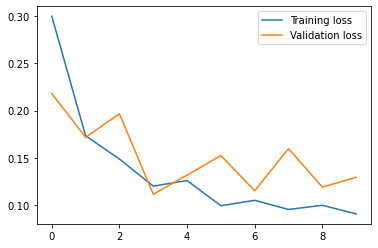

In [14]:
# fit the model
history = model.fit(trainX, trainY, epochs=10, batch_size=16, validation_split=0.2, verbose=1)
#history = model.fit(trainX, trainY, epochs=10, batch_size=100, validation_split=0.2, verbose=1)
#history = model.fit(trainX, trainY, epochs=10, batch_size=20, validation_split=0.2, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

1584


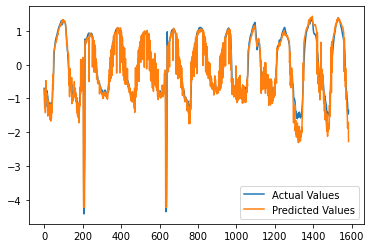

In [15]:
# (predict test set of training split)
pred_y = model.predict(trainX)
print(len(pred_y))
# add seasonality of the past year
#print(pred_y)
plt.plot(pred_y, label='Predicted Values')
plt.plot(trainY, label='Actual Values')
plt.legend()
#for i in np.arange(pred_y.shape[0]-1,-1,-1):
#    pred_y[pred_y.shape[0]-1-i] += result.seasonal[-(13+i):-(1+i)]

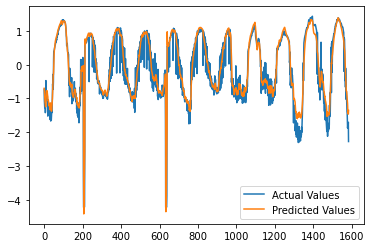

In [16]:
plt.plot(trainY, label='Actual Values')
plt.plot(pred_y, label='Predicted Values')
plt.legend()

MSE:  85703.73
RMSE:  292.75198


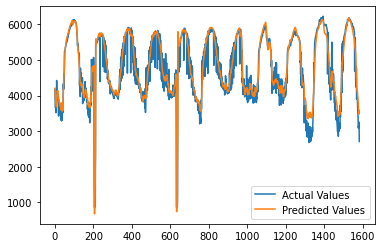

In [17]:
#print(pred_y)
pred_copies = np.repeat(pred_y, training_df_scaled.shape[1], axis=-1)    
#print(pred_copies)
inversed_predY = scaler.inverse_transform(pred_copies)
inversed_predY = np.transpose(inversed_predY)
#print(inversed_predY)

actual_copies = np.repeat(trainY, training_df_scaled.shape[1], axis=-1)    
inversed_actualY = scaler.inverse_transform(actual_copies)
inversed_actualY = np.transpose(inversed_actualY)

plt.plot(inversed_actualY[0], label='Actual Values')
plt.plot(inversed_predY[0], label='Predicted Values')
#print(len(inversed_predY[0]))
plt.legend()

print('MSE: ',mean_squared_error(inversed_actualY[0],inversed_predY[0]))
print('RMSE: ',RSME(inversed_predY[0],inversed_actualY[0]))


144


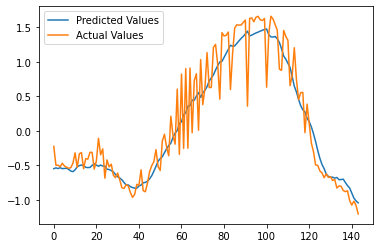

In [18]:
# (predict test set of testing split)
test_pred_y = model.predict(testX)
print(len(test_pred_y))
# add seasonality of the past year
#print(pred_y)
plt.plot(test_pred_y, label='Predicted Values')
plt.plot(testY, label='Actual Values')
plt.legend()

MSE:  68143.03
RMSE:  261.0422


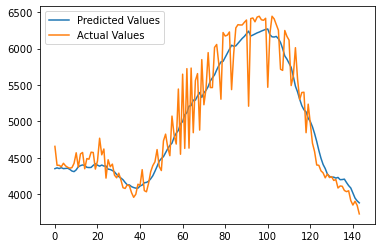

In [19]:
#print(pred_y)
pred_copies_test = np.repeat(test_pred_y, testing_df_scaled.shape[1], axis=-1)    
#print(pred_copies)
inversed_predY_test = scaler.inverse_transform(pred_copies_test)
inversed_predY_test = np.transpose(inversed_predY_test)
#print(inversed_predY)

actual_copies_test = np.repeat(testY, testing_df_scaled.shape[1], axis=-1)    
inversed_actualY_test = scaler.inverse_transform(actual_copies_test)
inversed_actualY_test = np.transpose(inversed_actualY_test)

plt.plot(inversed_predY_test[0], label='Predicted Values')
#print(len(inversed_predY[0]))
plt.plot(inversed_actualY_test[0], label='Actual Values')
plt.legend()

print('MSE: ',mean_squared_error(inversed_actualY_test[0],inversed_predY_test[0]))
print('RMSE: ',RSME(inversed_predY_test[0],inversed_actualY_test[0]))